In [1]:
from functools import reduce

import warnings
import cufflinks as cf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score,davies_bouldin_score
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.impute import SimpleImputer
from scikitplot.metrics import plot_roc,plot_ks_statistic
from sklearn.ensemble import RandomForestClassifier

cf.go_offline()
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
ruta='/home/asm/amv/credit_scoring/datos/GiveMeSomeCredit'
df=pd.read_csv(ruta+'/cs-training.csv',index_col=0)
df.reset_index(drop=True,inplace=True)
df.insert(0,'ID',df.index+1)
df.head()

,ID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [3]:
target=['SeriousDlqin2yrs']

um=['ID']

varc=['RevolvingUtilizationOfUnsecuredLines']

vard=['NumberOfTimes90DaysLate','NumberOfTime30-59DaysPastDueNotWorse',
      'NumberOfTime60-89DaysPastDueNotWorse','age']

df=df[um+target+varc+vard]

## k-means clustering

### Imputación y estandarización de datos

In [4]:
imp=SimpleImputer(strategy='median')
imp.fit(df[varc+vard])
mms=MinMaxScaler()
X=mms.fit_transform(imp.transform(df[varc+vard]))
X=pd.DataFrame(X,columns=varc+vard)
X[um+target]=df[um+target]
X.head()

,RevolvingUtilizationOfUnsecuredLines,NumberOfTimes90DaysLate,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,age,ID,SeriousDlqin2yrs
0,0.000015,0.000000,0.020408,0.0,0.412844,1,1
1,0.000019,0.000000,0.000000,0.0,0.366972,2,0
2,0.000013,0.010204,0.010204,0.0,0.348624,3,0
3,0.000005,0.000000,0.000000,0.0,0.275229,4,0
4,0.000018,0.000000,0.010204,0.0,0.449541,5,0


### Elección del número de clusters

In [5]:
db_score=[]
for k in range(2,11):
    km=KMeans(n_clusters=k,random_state=1234)
    km.fit(X[varc+vard])
    db_score.append(davies_bouldin_score(X[varc+vard],km.labels_))
db_score=pd.Series(dict(zip(range(2,11),db_score)))
db_score.iplot(kind='line',title='Davies Bouldin Score',colors='blue')

## Descripción de los clusters

In [6]:
k=3 # número optimo de clusters
km=KMeans(n_clusters=k,random_state=1234)
km.fit(X[varc+vard])
df['cluster']=km.labels_
df.head()

,ID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,NumberOfTimes90DaysLate,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,age,cluster
0,1,1,0.766127,0,2,0,45,1
1,2,0,0.957151,0,0,0,40,1
2,3,0,0.658180,1,1,0,38,1
3,4,0,0.233810,0,0,0,30,1
4,5,0,0.907239,0,1,0,49,1


In [7]:
df['cluster'].value_counts(1) # proporción de cada cluster

cluster
1    0.514233
0    0.483973
2    0.001793
Name: proportion, dtype: float64

In [8]:
pd.crosstab(df['cluster'],df['SeriousDlqin2yrs'],normalize='index') # porcentaje de buenos y malos por cluster

SeriousDlqin2yrs,0,1
cluster,,
0,0.959777,0.040223
1,0.909782,0.090218
2,0.453532,0.546468


In [9]:
df[target].value_counts(normalize=True) # porcentaje de buenos y malos en la población

SeriousDlqin2yrs
0                   0.93316
1                   0.06684
Name: proportion, dtype: float64

In [10]:
df.groupby('cluster')[varc+vard].agg(['mean','median']) # estadísticos de las variables por cluster

RevolvingUtilizationOfUnsecuredLines            \
                                        mean    median   
cluster                                                  
0                                   4.500396  0.079999   
1                                   7.522991  0.269808   
2                                   1.000000  1.000000   

        NumberOfTimes90DaysLate        NumberOfTime30-59DaysPastDueNotWorse  \
                           mean median                                 mean   
cluster                                                                       
0                      0.055375    0.0                             0.196526   
1                      0.123472    0.0                             0.292163   
2                     97.962825   98.0                            97.962825   

               NumberOfTime60-89DaysPastDueNotWorse               age         
        median                                 mean median       mean median  
cluster                                                                       
0          0.0                             0.043584    0.0  64.799920   63.0  
1          0.0                             0.084812    0.0  40.589279   42.0  
2         98.0                            97.962825   98.0  34.245353   29.0

* cluster 0: Adultos mayores que han presentado pocos atrasos en el pago de sus créditos y tienen un RevolvingUtilizationOfUnsecuredLines bajo (tienen limite de credito alto)
* cluster 1: Personas de mediana edad que han presentado pocos atrasos en el pago de sus créditos y tienen un RevolvingUtilizationOfUnsecuredLines medio 
* cluster 2: Personas jovenes que han presentado atrasos en el pago de sus créditos y tienen un RevolvingUtilizationOfUnsecuredLines de 1 (limite de credito igual al sado en su tarjeta de credito)) 

## Segmentación

In [11]:
s0=df[df['cluster']==0].reset_index(drop=True)
s1=df[df['cluster']==1].reset_index(drop=True)
s2=df[df['cluster']==2].reset_index(drop=True)

### Modelo del segmento 0

In [12]:
train0,test0=train_test_split(s0,test_size=0.3,random_state=1234,stratify=s0[target])
train0.reset_index(drop=True,inplace=True)
test0.reset_index(drop=True,inplace=True)
train0.shape,test0.shape

((50817, 8), (21779, 8))

In [13]:
modelo0=RandomForestClassifier()
grid={'n_estimators':range(20,201,20),'max_depth':range(2,6),'criterion':['gini','entropy'],'class_weight':['balanced',None],'max_features':['sqrt','log2'],'n_jobs':[-1]}
gs0=RandomizedSearchCV(modelo0,grid,n_iter=100,scoring='roc_auc',n_jobs=-1,random_state=1234)
gs0.fit(train0[varc+vard],np.ravel(train0[target]))
modelo0=gs0.best_estimator_
modelo0

RandomForestClassifier(criterion='entropy', max_depth=5, n_jobs=-1)

In [14]:
roc_auc_score(train0[target],modelo0.predict_proba(train0[varc+vard])[:,1]),roc_auc_score(test0[target],modelo0.predict_proba(test0[varc+vard])[:,1])

(0.8598840446715029, 0.8579583571168151)

### Modelo del segmento 1

In [15]:
train1, test1 = train_test_split(s1, test_size=0.3, random_state=1234, stratify=s1[target])
train1.reset_index(drop=True, inplace=True)
test1.reset_index(drop=True, inplace=True)
train1.shape, test1.shape

((53994, 8), (23141, 8))

In [16]:
modelo1=RandomForestClassifier()
gs1 = RandomizedSearchCV(modelo1, grid, n_iter=100, scoring='roc_auc', n_jobs=-1, random_state=1234)
gs1.fit(train1[varc+vard], np.ravel(train1[target]))
modelo1 = gs1.best_estimator_
modelo1

RandomForestClassifier(criterion='entropy', max_depth=5, max_features='log2',
                       n_estimators=200, n_jobs=-1)

In [17]:
roc_auc_score(train1[target], modelo1.predict_proba(train1[varc+vard])[:, 1]),roc_auc_score(test1[target], modelo1.predict_proba(test1[varc+vard])[:, 1])

(0.8370382512137037, 0.8332547140195163)

### Modelo del segmento 2

In [18]:
train2, test2 = train_test_split(s2, test_size=0.3, random_state=1234, stratify=s2[target])
train2.reset_index(drop=True, inplace=True)
test2.reset_index(drop=True, inplace=True)
train2.shape, test2.shape

((188, 8), (81, 8))

In [19]:
modelo2=RandomForestClassifier()
gs2 = RandomizedSearchCV(modelo2, grid, n_iter=100, scoring='roc_auc', n_jobs=-1, random_state=1234)
gs2.fit(train2[varc+vard], np.ravel(train2[target]))
modelo2 = gs2.best_estimator_
modelo2

RandomForestClassifier(class_weight='balanced', max_depth=2,
                       max_features='log2', n_estimators=160, n_jobs=-1)

In [20]:
roc_auc_score(train2[target], modelo2.predict_proba(train2[varc+vard])[:, 1]),roc_auc_score(test2[target], modelo2.predict_proba(test2[varc+vard])[:, 1])

(0.7155910908052541, 0.7128378378378379)

## Aplicaciond de los modelos

In [21]:
s0[['proba_0','proba_1']]=modelo0.predict_proba(s0[varc+vard])
s1[['proba_0','proba_1']]=modelo1.predict_proba(s1[varc+vard])
s2[['proba_0','proba_1']]=modelo2.predict_proba(s2[varc+vard])

In [22]:
tad=pd.concat([s0,s1,s2],axis=0).reset_index(drop=True)
tad.head()

,ID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,NumberOfTimes90DaysLate,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,age,cluster,proba_0,proba_1
0,6,0,0.213179,0,0,0,74,0,0.985896,0.014104
1,7,0,0.305682,0,0,0,57,0,0.977503,0.022497
2,10,0,0.189169,0,0,0,57,0,0.984433,0.015567
3,15,0,0.019657,0,0,0,76,0,0.992414,0.007586
4,16,0,0.548458,0,0,0,64,0,0.965656,0.034344


In [23]:
roc_auc_score(tad[target],tad['proba_1'])

0.8576434278434617

In [24]:
from sklearn.ensemble import  VotingClassifier

In [25]:
train,test=train_test_split(tad,test_size=0.3,random_state=1234,stratify=tad[target])
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)
train.shape,test.shape

((105000, 10), (45000, 10))

In [31]:
vc=VotingClassifier(estimators=[('m0',modelo0),('m1',modelo1),('m2',modelo2)],voting='soft',n_jobs=-1,weights=[0.483973,0.514233,0.001793])
vc.fit(train[varc+vard],train[target])

VotingClassifier(estimators=[('m0',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=5, n_jobs=-1)),
                             ('m1',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=5,
                                                     max_features='log2',
                                                     n_estimators=200,
                                                     n_jobs=-1)),
                             ('m2',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=2,
                                                     max_features='log2',
                                                     n_estimators=160,
                                                     n_jobs=-1))],
                 n_jobs=-1, voting='soft',
                 weights=[0.483973, 0.514233, 0.001793])

In [32]:
roc_auc_score(train[target],vc.predict_proba(train[varc+vard])[:,1]),roc_auc_score(test[target],vc.predict_proba(test[varc+vard])[:,1])

(0.857675402445517, 0.8548199316650487)

<Axes: title={'center': 'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

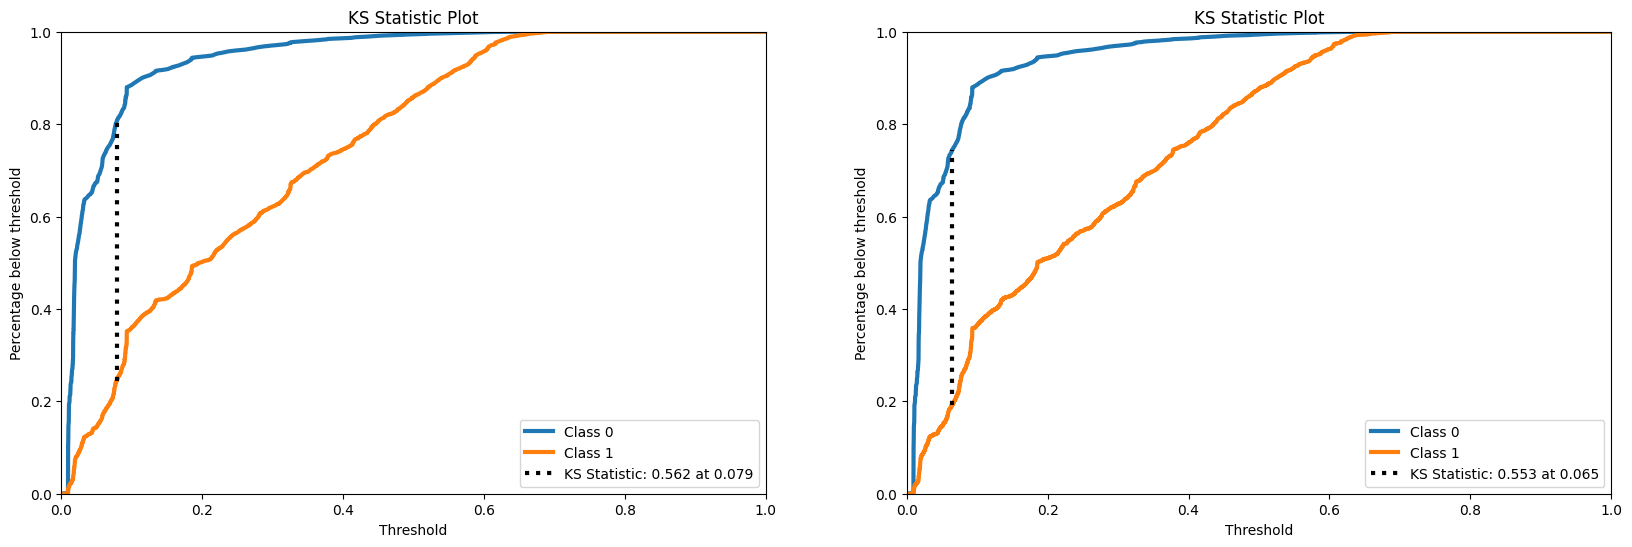

In [38]:
fig,ax=plt.subplots(1,2,figsize=(20,6))
plot_ks_statistic(train[target],vc.predict_proba(train[varc+vard]),ax=ax[0])
plot_ks_statistic(test[target],vc.predict_proba(test[varc+vard]),ax=ax[1])

In [33]:
pred=pd.read_csv(ruta+'/cs-test.csv')
pred['cluster']=km.predict(pred[varc+vard])
pred['Id']=pred.index+1
pred['Probability']=vc.predict_proba(pred[varc+vard])[:,1]
pred[['Id','Probability']].to_csv(ruta+'/pred_segmentacion.csv',index=False)
pred.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0
